# Adaptive Stitching
This code performs adaptive stitching for randomly spaced microlenses that are multifocal and have aberrations added to them. The adaptive stitching is needed for the microlenses to be correctly 3D printed with Nanoscribe. The code places the stitching artifacts at the boundaries of the microlenses and thus maximizes optical quality. 

The demonstration here will be for the 36 multifocal microlenses with astigmatism and tilt added. This was used in the paper: **Miniscope3D: optimized single-shot miniature 3D fluorescence microscopy**

In [1]:
%pylab
%matplotlib inline
import matplotlib.pyplot as plt
import TipSlicerUpdated
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage.morphology as im

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# this is the internal potential calculation for a single lens extracted for reuse in the masking def
def AberPotential(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint,Z=params
    Xn =  X/1800.
    Yn =  Y/1800.
    n=indexPoint
    Xnzern=Xn- xpos[n]/1800.
    Ynzern=Yn- ypos[n]/1800.
    r = np.sqrt(np.square(Xnzern) + np.square(Ynzern))
    Z2  =  Z[n,0]  * 2.*Xnzern
    Z3  =  Z[n,1]  * 2.*Ynzern
    Z5  =  Z[n,2]  * 2.*np.sqrt(6.)*Xnzern*Ynzern
    Z6  =  Z[n,3]  * np.sqrt(6.)*(Xnzern**2-Ynzern**2)
    #Z12 =  Z[n,4] * np.sqrt(10.)*(Xnzern**2-Ynzern**2)*(4*r**2-3)
    #Z13 =  Z[n,5] * 2*np.sqrt(10.)*Xnzern*Ynzern*(4*r**2-3)
    #Z23 =  Z[n,6] * 2*np.sqrt(14.)*Xnzern*Ynzern*(15*r**4-20*r**2+6)
    #Z24 =  Z[n,7] * np.sqrt(14.)*(Xnzern**2-Ynzern**2)*(15*r**4-20*r**2+6)
    ZW = Z5+Z6+Z2+Z3#+Z12+Z13+Z23+Z24
    sph1 = ZW+np.real(np.sqrt(0j+rlist[n]**2 - (X-xpos[n])**2 - (Y-ypos[n])**2))-np.real(np.sqrt(0j+rlist[n]**2-r_lenslet**2))-(z-height)
    return sph1


def sliceFormulaAber(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint,aber=params
    aper=np.sqrt(X**2+Y**2) <= aperR
    Z=aber
    if z<=height:        
        return aper
    else:                         
        T = np.zeros(len(X))
        inds=range(len(xpos))
        if (indexPoint>-1):
            inds=[indexPoint]
        for n in inds:
            sph1=AberPotential(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,n,aber])
            T = np.maximum(T,sph1)
            T=(T>0)
        return (T)*aper
    
def maskFormulaAber(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint,aber=params
    aper=np.sqrt(X**2+Y**2) <= aperR
    if (z<=height):
        z=height    
    DD=np.zeros((len(xpos),X.shape[0],X.shape[1]))
    for i in np.arange(len(DD)):
        DD[i]=-AberPotential(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,i,aber])*aper
    Div=np.argmin(DD,axis=0)
    if (indexPoint==-1):
        return Div
    else:
        return np.where(Div==indexPoint,1,0)*aper

# extract the centres from the structure itself
def getCentresAber(X,Y,z,params):
    xpos,ypos,rlist,r_lenslet,height,aperR,indexPoint,aber=params
    aper=np.sqrt(X**2+Y**2) <= aperR
    centList=[]
    for i in np.arange(len(xpos)):
        DD=-AberPotential(X,Y,z,[xpos,ypos,rlist,r_lenslet,height,aperR,i,aber])
        xc,yc=np.unravel_index(np.argmin(DD*aper),DD.shape)
        centList.append([yc,xc])
    Cents=np.asarray(centList)
    return Cents

# Define microlens array parameters

In [3]:
#all units are in microns
r_lenslet=200   #average diameter of each microlens
samples = (1800,1800)  #how many samples
xgrng = np.array((-900, 900)) #physical dimension of the microlens array in microns  (1.8 mm here)
xgrng2 = np.array((-1800, 1800)) #in microns
ygrng=xgrng
ygrng2=xgrng2


yg = np.linspace(ygrng[0], ygrng[1], samples[0])
xg=yg
px=xg[1] - xg[0]
py=px
X,Y= np.meshgrid(xg,yg)

yg2 = np.linspace(ygrng2[0], ygrng2[1], samples[0])
xg2=yg2
px2=xg2[1] - xg2[0]
py2=px2
X2,Y2= np.meshgrid(xg2,yg2)

Xn =  X2/np.max(X2)
Yn =  Y2/np.max(Y2)

# xposition list in mm
xpos=np.array([ 0.43641585,  0.29636857,  0.21274264,  0.6394599 ,  0.65087426,
        -0.49792665, -0.11775845,  0.59266114, -0.1886654 , -0.45093933,
        -0.06002499,  0.49039292,  0.18374896,  0.32612935,  0.5355058 ,
        -0.07172677,  0.75601995, -0.27811506, -0.24367642, -0.22418435,
         0.22841486, -0.67916805, -0.6805813 , -0.00778827,  0.8232382 ,
        -0.30767533,  0.19155966,  0.46077853,  0.10799856, -0.23324046,
        -0.4479409 ,  0.13673823, -0.42627445, -0.02470369, -0.46301848,
        -0.6288782 ], dtype=float32)
# yposition list in mm
ypos=np.array([-0.0961623 , -0.590606  ,  0.07416802,  0.08558229, -0.2063948 ,
         0.22398773, -0.66743815, -0.4089036 , -0.48776114, -0.01421136,
         0.48614654,  0.47054946, -0.29256105, -0.4106429 , -0.5639799 ,
         0.6772651 ,  0.26205382,  0.5754221 ,  0.10239594, -0.2096889 ,
         0.47864714, -0.39620727,  0.18052123,  0.17819166,  0.07138762,
        -0.68207985, -0.7970757 ,  0.18449856, -0.4582133 ,  0.37643924,
         0.50502807,  0.66083544, -0.18756227, -0.07771606, -0.5855127 ,
        -0.00837374], dtype=float32)
#radius of curvature in mm
rlist=np.array([ 6.306523 ,  6.453186 , 16.322765 ,  7.4996486, 12.613046 ,
        5.780979 , 12.064652 ,  6.032326 , 17.342937 ,  6.6068335,
        7.1150513, 19.8205   ,  8.408697 , 11.09948  ,  7.9282   ,
        9.91025  ,  8.161383 , 13.87435  ,  7.3022895, 11.561958 ,
       14.604579 ,  9.249567 ,  9.568518 ,  6.767976 ,  5.903979 ,
        7.707972 , 18.499134 , 10.672577 ,  6.937175 ,  6.1663775,
       15.415944 , 10.277296 ,  8.671469 ,  8.951194 ,  5.663    ,
       13.213667 ],dtype=float32) 

#zernike list in mm
zernlist=np.array([[-3.03727644e-03,  3.45289009e-03, -8.50316486e-04,
         -9.94477305e-04],
        [ 2.08902825e-03, -5.25590964e-03, -5.57003869e-03,
          1.66087621e-03],
        [-1.54656521e-03, -7.22034927e-03, -1.47716681e-04,
          1.33255846e-03],
        [-6.46650698e-03, -1.09545095e-03, -1.48787047e-03,
          2.08820638e-04],
        [ 4.51811217e-03, -1.51357264e-03,  1.89111437e-04,
          3.22496460e-04],
        [-1.23638997e-03,  1.33150117e-03, -5.25358878e-03,
          9.76655632e-03],
        [ 4.36959649e-03, -7.47654727e-03,  3.64801125e-03,
         -1.86670839e-03],
        [-1.29632989e-03, -8.81011318e-03, -2.17094715e-03,
          5.12582343e-03],
        [-3.18442448e-03, -7.02016230e-04, -7.80638075e-04,
          8.95439996e-04],
        [ 1.33037404e-03, -4.07017302e-03,  1.83174980e-03,
          4.63185087e-03],
        [ 6.37175108e-04,  3.62162525e-03, -1.38857099e-03,
         -1.69407239e-03],
        [ 4.18911048e-04,  2.99920258e-03, -6.04745280e-03,
         -2.02366011e-03],
        [ 7.84681237e-04,  2.57954700e-03,  8.30374379e-03,
         -5.63086197e-03],
        [-9.27667075e-04,  7.60378689e-03,  5.11155883e-03,
         -2.85442872e-03],
        [ 3.69066279e-03,  1.44687016e-03,  3.64636071e-03,
         -1.35618821e-03],
        [ 3.47679667e-03,  9.66886338e-03,  6.05431778e-05,
          2.10903143e-03],
        [-7.06169615e-03,  1.05272122e-02, -2.37144646e-03,
          2.14290898e-03],
        [-3.13660316e-03,  7.06096133e-03, -8.40417400e-04,
         -2.18926976e-03],
        [ 7.11004948e-03,  2.00309485e-04,  1.43178422e-02,
          9.40302107e-03],
        [ 5.73336380e-03,  4.81330231e-03, -6.11291872e-03,
         -5.15368767e-03],
        [-2.86504888e-04, -1.82941454e-04,  8.74243851e-04,
          1.06786657e-03],
        [-4.43635369e-03,  3.36597041e-05, -3.35925579e-04,
         -2.17877914e-06],
        [-4.91749262e-03,  5.81631484e-03,  6.35021715e-04,
          1.07655076e-04],
        [-7.96477543e-04,  1.53168791e-03,  7.15573411e-03,
         -7.31880311e-03],
        [ 5.98072400e-03,  1.42488685e-02, -8.81085114e-04,
         -4.13347734e-03],
        [-4.52623982e-03, -2.22414453e-03,  2.17066554e-05,
         -1.89099193e-03],
        [-3.83377355e-03,  6.57709083e-04,  6.44097291e-03,
          1.02351094e-03],
        [-3.02775938e-04,  2.83448049e-03,  1.72653550e-03,
         -2.10265117e-03],
        [ 1.72412605e-03, -8.58071493e-04,  6.27913105e-04,
         -4.08340804e-03],
        [ 2.68175127e-03, -1.63576938e-03, -9.31847002e-03,
         -1.93845030e-04],
        [-5.83293755e-03,  1.95736508e-03, -2.00207127e-04,
         -1.04814884e-03],
        [ 3.55686457e-03,  7.30788289e-03, -9.41661303e-04,
          4.80500096e-03],
        [ 6.76476862e-04, -2.14314481e-04, -7.66097510e-04,
         -2.71079480e-03],
        [-3.65834520e-03,  7.38649350e-03,  1.80285275e-02,
         -1.13024702e-02],
        [-7.70746637e-03, -1.72380230e-03,  5.40864607e-03,
         -1.24156917e-03],
        [-4.90240427e-03, -6.24271634e-04,  2.45964224e-03,
         -1.91784347e-04]],dtype=float32)
    


Nlenslets=36  #number of microlenses
#convert from mm to microns
xpos=np.reshape(xpos,(36))*1000
ypos=np.reshape(ypos,(36))*1000
rlist=np.reshape(rlist,(36))*1000
zernlist=zernlist*1000

height=50 #how much of support material to be printed under the phase mask (in microns)
aperR=900 #radius of phase mask (collection of microlenses)

In [4]:
X3,Y3=np.meshgrid(np.arange(-1000,1000),np.arange(-1000,1000))

# Let's visualize our microlens array after adaptive stitching

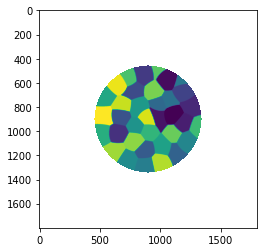

In [8]:
z=50     # this is for visualization only, this the height in microns where you want to see the slice

lens=-1  # putting this to a number between 0 and Nlenslets will show you what each block does
         # setting it to -1 will show all lenses..
clf()
Back=sliceFormulaAber(X2,Y2,z,[xpos,ypos,rlist,r_lenslet,height,aperR,-1,zernlist])
T=sliceFormulaAber(X2,Y2,z,[xpos,ypos,rlist,r_lenslet,height,aperR,lens,zernlist])
Mask=maskFormulaAber(X2,Y2,z,[xpos,ypos,rlist,r_lenslet,height,aperR,lens,zernlist])
Res=T*(Mask)
Back=np.where(Back==0,NaN,Back)
imshow(Back+Res)



## Now get the Centres of the lenses (most negative dist) as xpos, ypos not ideal

In [9]:
# Note that there might be a small dependency on the height, taken 53 here but this can be changed..
Cents=getCentresAber(X2,Y2,51,[xpos,ypos,rlist,r_lenslet,height,aperR,-1,zernlist])
CCentsX=X2[0,Cents[:,0]]
CCentsY=Y2[Cents[:,1],0]

(-810.9505280711508, 939.0216787103948, -876.3868816008894, 860.3779877709837)

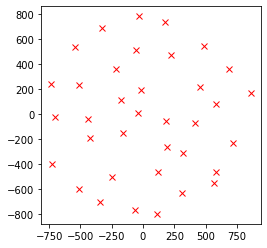

In [10]:
clf()
plot(CCentsX,CCentsY,'rx')
plt.axis('image')

# Now start with Nanoscribe file

In [11]:
optPoints=np.column_stack((CCentsX,CCentsY))

11402.334630350195


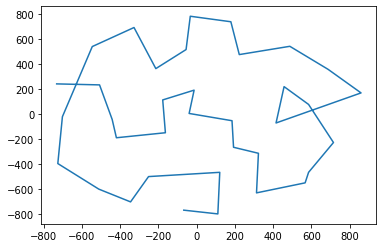

In [14]:
# let's optimize the path for printing
Ord,NNd=TipSlicerUpdated.TSPnearest(optPoints)
plot(optPoints[Ord][:,0],optPoints[Ord][:,1],'-')
print(NNd)

### First check different FOV + Blocks to see if FOV big enough

In [15]:
i=0
Fov=400  # This is important! How big of a fov in microns you are trying to print before the stage moves (can get away with up to 400)
hatching=0.2 
am=np.int(np.round(Fov/hatching))
z=50

In [18]:
xc=optPoints[Ord[i],0]
yc=optPoints[Ord[i],1]

xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
Xloc,Yloc=np.meshgrid(xx,yy)
print('Working on {}'.format(Ord[i]))

#Back=sliceFormulaAber(Xloc,Yloc,z,[xpos,ypos,rlist,r_lenslet,height,aperR,-1,zernlist])
T=sliceFormulaAber(Xloc,Yloc,z,[xpos,ypos,rlist,r_lenslet,height,aperR,Ord[i],zernlist])
Mask=maskFormulaAber(Xloc,Yloc,z,[xpos,ypos,rlist,r_lenslet,height,aperR,Ord[i],zernlist])
Res=T*(Mask)
#Back=np.where(Back==0,NaN,Back)
#imshow(Back+Res)
#print(i)
#i=i+1

Working on 22


In [22]:
# this name will define the sub-folder that will be written to
rootName='MicroAberStitch_36lenses_pdms_01_500fov_corrected'


# Let's write the files need for the Nanoscribe printer
This will take some time to run

In [23]:
#%%%time
# STEP 1: Write out the H5 stacks, intermediate format that is equivalent to a sliced STL
#         => only changes if you change parameters here (slicing,hashing,writing height)
#         => for other variations (number of shells etc..) you don't have to rerun this

FovZ=54.120638  # should be maximum size of total element, used for slice determination
height=50
roughSlicing=2
fineSlicing=0.1
zzbase=np.arange(0,height,roughSlicing)  # speed up writing of base
zzlenses=np.arange(height,FovZ,fineSlicing)
zz=np.append(zzbase,zzlenses)


Fov=500  # 600 is quite a lot, but using the 25x, could be possible. 
         # diameter of writing circle, using the Galvo and the 25x, 400µm is definitely writeable, 
         # it just implies the voxel might get deformed by optical aberrations of the objective
         # => you can expect some quality decrease but no doubt still better than having a stitching line..

hatching=0.2 #should be 0.2
am=np.int(np.round(Fov/hatching))  



#overlapXY_multiplier=3 # this is how much the different stitching blocks would overlap (this x hatching). 
# the masks are not overlapping for the moment, if we want this, needs to be implemented in masking function..

if (not os.path.exists(rootName)):
    os.mkdir(rootName)
if (not os.path.exists(rootName+'/h5data')):
    os.mkdir(rootName+'/h5data')
if (not os.path.exists(rootName+'/data')):
    os.mkdir(rootName+'/data')
genBlockName=rootName+'/h5data/'+rootName+'_Block_{:05d}.h5'
genGwlName=rootName+'/data/'+rootName+'_Block_{:05d}.gwl'
genRegex=rootName+'/data/.+gwl'
fullGwlName=rootName+'/'+rootName+'.gwl'

for i in np.arange(len(Ord)):
#for i in np.arange(5):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    xc=optPoints[Ord[i],0]
    yc=optPoints[Ord[i],1]

    xx=np.linspace(xc-Fov/2.0,xc+Fov/2.0,am)
    yy=np.linspace(yc-Fov/2.0,yc+Fov/2.0,am)
    Xloc,Yloc=np.meshgrid(xx,yy)
    
    # make specific mask
#    MM=maskFormula(Xloc,Yloc,z,maskParams)
    # if you need overlap, do binary_dilation on the mask
#    MM=im.binary_dilation(MM,iterations=overlapXY_multiplier)
    
    # with these coordinate systems, apply formulaToStack
    blockName=genBlockName.format(i)
    
    extras=[xpos,ypos,rlist,r_lenslet,height,aperR,Ord[i],zernlist]
    Mask=maskFormulaAber(Xloc,Yloc,50.1,[xpos,ypos,rlist,r_lenslet,height,aperR,Ord[i],zernlist])
    
    # if you need overlap between the masks, apply some dilation here..
    Mask=im.binary_dilation(Mask,iterations=3)
    
    TipSlicerUpdated.formulaToStack(blockName,Xloc,Yloc,zz,sliceFormulaAber,writingMask=Mask,extraParams=extras)
    
    

Writing block 0
Writing block 1
Writing block 2
Writing block 3
Writing block 4
Writing block 5
Writing block 6
Writing block 7
Writing block 8
Writing block 9
Writing block 10
Writing block 11
Writing block 12
Writing block 13
Writing block 14
Writing block 15
Writing block 16
Writing block 17
Writing block 18
Writing block 19
Writing block 20
Writing block 21
Writing block 22
Writing block 23
Writing block 24
Writing block 25
Writing block 26
Writing block 27
Writing block 28
Writing block 29
Writing block 30
Writing block 31
Writing block 32
Writing block 33
Writing block 34
Writing block 35


In [24]:
#%%%time
# STEP 2: Write out GWL files based on H5 files from above

amShells=5
ScaffStep=2 # for solid infill => 2*hatching is spacing here
hatchStep=1 # for contour distance and top-bottom infill, not used if amShells==1 and doTopBottom=False


# the definition below will be used to increase the writing laser power when the slicing is larger
# below the base height, the intensity will be ? times larger, above it the nominal one will be used.
def intensityMultiplier(z):
    if (z<height):
        return 5.0
    else:
        return 1.0

#overlapXY_multiplier=3 # this is how much the different stitching blocks would overlap (this x hatching). 
# the masks are not overlapping for the moment, if we want this, needs to be implemented in masking function..

rootName='MicroAberStitch_36lenses_pdms_01_500fov_corrected'
if (not os.path.exists(rootName)):
    os.mkdir(rootName)
if (not os.path.exists(rootName+'/h5data')):
    os.mkdir(rootName+'/h5data')
if (not os.path.exists(rootName+'/data')):
    os.mkdir(rootName+'/data')
genBlockName=rootName+'/h5data/'+rootName+'_Block_{:05d}.h5'
genGwlName=rootName+'/data/'+rootName+'_Block_{:05d}.gwl'
genRegex=rootName+'/data/.+gwl'
fullGwlName=rootName+'/'+rootName+'.gwl'

writeColour=False  # will output a H5 file with the gwl-lines; not necessary at all

distList=[]
for i in np.arange(len(Ord)):
#for i in np.arange(3):
    # now make coordinate systems
    print('Writing block {}'.format(i))
    
    blockName=genBlockName.format(i)
    
    dists=TipSlicerUpdated.stackToGwl(blockName,genGwlName.format(i),amShells,ScaffStep,hatchStep
                                   ,atAngles=-1,writeHeader=False,writeColourH5=writeColour,doTopBottom=True,ZscalerFunc=intensityMultiplier)
    try:
        distList.append(dists)
    except:
        print('Could not add dist to list',dists)
    
TipSlicerUpdated.writeGwlForRegex(fullGwlName,genRegex)

Writing block 0
Writing block 1
Writing block 2
Writing block 3
Writing block 4
Writing block 5
Writing block 6
Writing block 7
Writing block 8
Writing block 9
Writing block 10
Writing block 11
Writing block 12
Writing block 13
Writing block 14
Writing block 15
Writing block 16
Writing block 17
Writing block 18
Writing block 19
Writing block 20
Writing block 21
Writing block 22
Writing block 23
Writing block 24
Writing block 25
Writing block 26
Writing block 27
Writing block 28
Writing block 29
Writing block 30
Writing block 31
Writing block 32
Writing block 33
Writing block 34
Writing block 35
